In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from numpy.random import shuffle
import random
np.set_printoptions(threshold=np.inf)

batch_size = 64  # Batch size for training.
epochs = 150  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 26000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'many_to_one_dataset.txt'
print(epochs)

Using TensorFlow backend.


150


In [14]:
data_path = 'dataset(only_bigram).txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
file = open('dataset(only_bigram_test).txt','w',encoding="utf-8")    
for line in lines:
    data=line.split()
    #print(len(data))
    if(len(data)==3):
        continue
    input_text, target_text = line.split('\t')
    data=input_text.split(' ')
    line=input_text+'\t'+data[0]+' '+target_text+' '+data[2]+'\n'
    file.write(line)
    
file.close() 

In [2]:
# Vectorize the data.
data_path = 'dataset(only_bigram_test).txt'
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    print(len(lines))
    print(lines[0])
    random.shuffle(lines)
    print(lines[0])
    
num_samples=137000    
for line in lines[: min(num_samples, len(lines) - 1)]:
    #print(line)
    input_text, target_text = line.split('\t')
    # We use tab('\t') as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

51400
স্মৃতিকথায় ঢাকার অলিগলি-তস্যগলি—মৈশণ্ডীপাড়া,	স্মৃতিকথায় ঢাকা অলিগলি-তস্যগলি—মৈশণ্ডীপাড়া,
কোলোতনাইতস্কার জিনতার আগরগাছের	কোলোতনাইতস্কার জিনতা আগরগাছের


In [3]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

print(input_characters)
print(target_characters)

Number of samples: 51399
Number of unique input tokens: 99
Number of unique output tokens: 100
Max sequence length for inputs: 63
Max sequence length for outputs: 64
[' ', '!', "'", '(', ')', ',', '-', '.', '/', ':', ';', '?', '[', ']', '|', '\x9d', '¬', '\xad', '²', '।', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র', 'ল', 'শ', 'ষ', 'স', 'হ', '়', 'া', 'ি', 'ী', 'ু', 'ূ', 'ৃ', 'ে', 'ৈ', 'ো', 'ৌ', '্', 'ৎ', 'ৗ', 'ড়', 'ঢ়', 'য়', '০', '১', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', '\u200c', '\u200d', '\u200f', '—', '‘', '’']
['\t', '\n', ' ', '!', '(', ')', ',', '-', '.', '/', ':', ';', '?', '[', ']', '|', '\x9d', '¬', '\xad', '²', '।', 'ঁ', 'ং', 'ঃ', 'অ', 'আ', 'ই', 'ঈ', 'উ', 'ঊ', 'ঋ', 'এ', 'ঐ', 'ও', 'ঔ', 'ক', 'খ', 'গ', 'ঘ', 'ঙ', 'চ', 'ছ', 'জ', 'ঝ', 'ঞ', 'ট', 'ঠ', 'ড', 'ঢ', 'ণ', 'ত', 'থ', 'দ', 'ধ', 'ন', 'প', 'ফ', 'ব', 'ভ', 'ম', 'য', 'র'

In [4]:
import json

data = {}  
data['input_output'] = []  
data['input_output'].append({  
    'num_encoder_tokens': num_encoder_tokens,
    'num_decoder_tokens': num_decoder_tokens,
    'max_encoder_seq_length': max_encoder_seq_length,
    'max_decoder_seq_length': max_decoder_seq_length
})

with open('important_data(only_bigram_test).txt', 'w') as outfile:  
    json.dump(data, outfile)

In [5]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [6]:
import json

print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

data = {}  
data['input_output'] = []  
data['input_output'].append({  
    'num_encoder_tokens': num_encoder_tokens,
    'num_decoder_tokens': num_decoder_tokens,
    'max_encoder_seq_length': max_encoder_seq_length,
    'max_decoder_seq_length': max_decoder_seq_length
})

data['input_index']=input_token_index;
data['target_index']=target_token_index;

with open('important_data(only_bigram_test).txt', 'w') as outfile:  
    json.dump(data, outfile)
    
#with open('important_data.txt', 'a') as outfile:  
 #   json.dump(input_token_index, outfile)   

Number of unique input tokens: 99
Number of unique output tokens: 100
Max sequence length for inputs: 63
Max sequence length for outputs: 64


In [7]:
all_char=[]
print(input_token_index)
print(target_token_index)
print(input_token_index['ক'])
print(np.shape(encoder_input_data))

{' ': 0, '!': 1, "'": 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, '/': 8, ':': 9, ';': 10, '?': 11, '[': 12, ']': 13, '|': 14, '\x9d': 15, '¬': 16, '\xad': 17, '²': 18, '।': 19, 'ঁ': 20, 'ং': 21, 'ঃ': 22, 'অ': 23, 'আ': 24, 'ই': 25, 'ঈ': 26, 'উ': 27, 'ঊ': 28, 'ঋ': 29, 'এ': 30, 'ঐ': 31, 'ও': 32, 'ঔ': 33, 'ক': 34, 'খ': 35, 'গ': 36, 'ঘ': 37, 'ঙ': 38, 'চ': 39, 'ছ': 40, 'জ': 41, 'ঝ': 42, 'ঞ': 43, 'ট': 44, 'ঠ': 45, 'ড': 46, 'ঢ': 47, 'ণ': 48, 'ত': 49, 'থ': 50, 'দ': 51, 'ধ': 52, 'ন': 53, 'প': 54, 'ফ': 55, 'ব': 56, 'ভ': 57, 'ম': 58, 'য': 59, 'র': 60, 'ল': 61, 'শ': 62, 'ষ': 63, 'স': 64, 'হ': 65, '়': 66, 'া': 67, 'ি': 68, 'ী': 69, 'ু': 70, 'ূ': 71, 'ৃ': 72, 'ে': 73, 'ৈ': 74, 'ো': 75, 'ৌ': 76, '্': 77, 'ৎ': 78, 'ৗ': 79, 'ড়': 80, 'ঢ়': 81, 'য়': 82, '০': 83, '১': 84, '২': 85, '৩': 86, '৪': 87, '৫': 88, '৬': 89, '৭': 90, '৮': 91, '৯': 92, '\u200c': 93, '\u200d': 94, '\u200f': 95, '—': 96, '‘': 97, '’': 98}
{'\t': 0, '\n': 1, ' ': 2, '!': 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, '/': 9, ':': 10, ';': 

In [8]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [9]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
epochs=10
batch_size=64
print(epochs)
# Run training
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])sparse_categorical_crossentropy
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          shuffle=True,
          validation_split=0.2)
# Save model


10
Train on 41119 samples, validate on 10280 samples
Epoch 1/10
41119/41119 [==============================] - 1895s 46ms/step - loss: 1.0643 - acc: 0.0834 - val_loss: 0.9592 - val_acc: 0.1038
Epoch 2/10
  256/41119 [..............................] - ETA: 1:34:45 - loss: 0.9205 - acc: 0.09 - ETA: 1:35:59 - loss: 0.9302 - acc: 0.1010

KeyboardInterrupt: 

In [23]:
model.save('s2s(only_bigram_test).h5')

C:\Users\RANA_CSE\Anaconda3\lib\site-packages\keras\engine\topology.py:2361: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [24]:
# Next: inference mode (sampling).
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
data_path = 'many_to_one.txt'
print("kire")
model = load_model('s2s(only_bigram).h5')


encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index[' ']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence




def get_input_data(test_txt):
    #txt = input()
    txt=test_txt
    
    encoder_input_data = np.zeros(
    (len(txt), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
    
    txt = txt.replace(' ', '')
    
    for t, char in enumerate(txt):
        encoder_input_data[0, t, input_token_index[char]] = 1.
        
    return encoder_input_data
    
    
    
    
# Take one sequence (part of the training set)
# for trying out decoding.
#input_seq = encoder_input_data[seq_index: seq_index + 1]

with open(data_path, 'r', encoding='utf-8') as f:
    test_lines = f.read().split('\n')

test_input_texts=[]
test_target_texts=[]
for line in test_lines[1: 100]:
    test_input_text, test_target_text = line.split('\t')
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text+'\n')
    
#print(test_input_texts)   

total_test_input=0
total_accuracy=0

for i in range(100):
    total_test_input=total_test_input+1
    input_seq = get_input_data(test_input_texts[i])
    decoded_sentence = decode_sequence(input_seq)
    if (decoded_sentence==test_target_texts[i]):
        total_accuracy=total_accuracy+1
        #print('hoiche')
        
    print('Input sentence:',   test_input_texts[i])
    print('Decoded sentence:', decoded_sentence)
    #print(decoded_sentence[6])
   # print('Target sentence:',  test_target_texts[i])
    #print(test_target_texts[i][6])
  
    
print('total_test_input:', total_test_input)
print('total_accuracy:', total_accuracy)
print('result:', (total_accuracy/total_test_input)*100,'%')

#yhat = model.predict(input_seq, verbose=0)
#print(yhat)

kire
Input sentence: জলছবিতে। বিনয়-বাদল-দীনেশ বাহিনীর
Decoded sentence: করে প্রতিশ্র করে

Input sentence: বিনয়-বাদল-দীনেশ বাহিনীর দাঙ্গা-সন্ত্রাসবিরোধী
Decoded sentence: করে প্রতিশ্র করে

Input sentence: বাহিনীর দাঙ্গা-সন্ত্রাসবিরোধী ওয়ারী
Decoded sentence: করে প্রতিশ্র করে

Input sentence: দাঙ্গা-সন্ত্রাসবিরোধী ওয়ারী অভিযানের
Decoded sentence: করে প্রতিশ্র করে

Input sentence: ওয়ারী অভিযানের চাঞ্চল্যকর
Decoded sentence: করে প্রতিশ্র করে

Input sentence: অভিযানের চাঞ্চল্যকর বর্ণনায়
Decoded sentence: করে প্রতিশ্র করে

Input sentence: চাঞ্চল্যকর বর্ণনায় ভাস্বর
Decoded sentence: করে প্রতিশ্র করে

Input sentence: বর্ণনায় ভাস্বর প্রতিভা
Decoded sentence: করে প্রতিশ্র করে

Input sentence: ভাস্বর প্রতিভা বসুর
Decoded sentence: করে প্রতিশ্র করে

Input sentence: প্রতিভা বসুর স্মৃতির
Decoded sentence: করে প্রতিশ্র করে

Input sentence: বসুর স্মৃতির কলম।
Decoded sentence: করে প্রতিশ্র করে

Input sentence: স্মৃতির কলম। পাড়া-মহল্লার
Decoded sentence: করে প্রতিশ্র করে

Input sentence: কলম। পাড়া-

IndexError: list index out of range

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


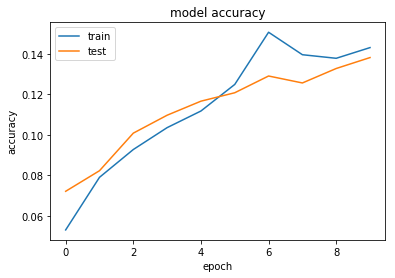

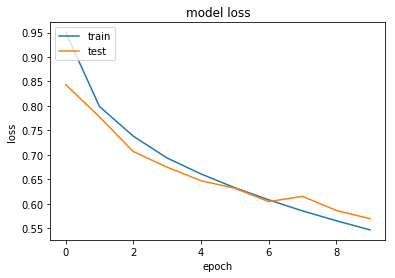

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()